In [1]:
from netCDF4 import Dataset, num2date, date2num
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
import xarray as xr
from pandas import Index

## Read FOCI-MOZ SAM index

In [2]:
%cd /sfs/fs1/work-geomar/smomw418/models/foci/experiments/SAM_index

/gxfs_work1/fs1/work-geomar/smomw418/models/foci/experiments/SAM_index


In [3]:
sw054 = xr.open_dataset('FOCI1.4-SW054_SAM_index_1958-2013.nc', decode_times=True)
sw064 = xr.open_dataset('FOCI1.4-SW064_SAM_index_1958-2013.nc', decode_times=True)
sw065 = xr.open_dataset('FOCI1.4-SW065_SAM_index_1958-2013.nc', decode_times=True)

## Read FOCI_HIST SAM index

In [4]:
sw060 = xr.open_dataset('FOCI1.7-SW060_SAM_index_1958-2013.nc', decode_times=True)
sw061 = xr.open_dataset('FOCI1.7-SW061_SAM_index_1958-2013.nc', decode_times=True)
jh019 = xr.open_dataset('FOCI1.9.4-JH019_SAM_index_1958-2013.nc', decode_times=True)

In [5]:
sw054

<xarray.Dataset>
Dimensions:     (lat: 96, lat_SH: 48, plev: 26, time: 20454)
Coordinates:
  * plev        (plev) float64 1e+03 925.0 850.0 775.0 700.0 ... 1.0 0.5 0.2 0.1
  * lat         (lat) float32 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
  * lat_SH      (lat_SH) float32 -0.9326 -2.798 -4.663 ... -84.86 -86.72 -88.57
  * time        (time) datetime64[ns] 1958-01-01T23:52:00 ... 2013-12-31T23:5...
Data variables:
    PC          (time, plev) float64 ...
    PC_trend    (time, plev) float64 ...
    EOF         (lat_SH, plev) float64 ...
    EOF_global  (plev, lat) float64 ...
    expvar      (plev) float64 ...
Attributes:
    Description:  SAM index and pattern from FOCI-MOZ experiment SW054 for th...

## Compute SAM timescale 

In [6]:
def ii_SAM_timescales(data):
    #-------------------------------------- SAM timescales ---------------------------------------------------
    # Input: SAM index for each pressure level
    # Apply a Gaussian filter (=weighted average) with a window of 181 days and a full width at half maximum of 60 days (sigma=26)
    # For each day of the year compute the 'autocorrelation function' (ACF) by correlating the yearly timeseries
    # for the particular day with the yearly timeseries for the days lagging or leading it (i.e. different laggs)
    # Doing this for each pressure level gives a 3D array containig the autocorrelations for each day of the year and each lag
    # Fit an exponenitial function to the (first 50 positive lags - Mudryk and Kushner 2011) ACF of each pressure level and day of the year
    # time scale = the e-folding time of the autocorrelation function of the annular mode index 
    # (time in days for the exponential function fitted to the autocorrelation function to drop to 1/e)
    # References: Simpson et al. 2011; other approaches in: Baldwin et al. 2003, Mudryk and Kushner 2011, Kim and Reichler 2016
    # Author: Ioana Ivanciu (08.10.2018) updated on 05.11.2018 to correct the filtering of theACF
    #----------------------------------------------------------------------------------------------------------
    
    import numpy as np
    import xarray as xr
    from ii_pyfunctions import ii_gaussian_filt
    from scipy.optimize import curve_fit
    from matplotlib import pyplot
    
    # Define function for exponential fit
    def func(x,  a):
        return np.exp(-a * x)
       
    # Remove 29th of February from leap years
    months = data['time.month']
    days = data['time.day']
    mask = ((months==2) & (days==29))
    data = data[mask==False,:]
    
    # arrays containing the year, month and day corresponding to each element of the SAM index
    years = data['time.year']
    yrs = np.unique(years.values) # unique years
    months = data['time.month']
    days = data['time.day']
    
    lag = np.arange(-150,151) # lags for wich the ACF is computed
    corr = np.zeros((len(data.plev), len(lag), 365)) # ACF value for each level, day of the year and lag
    corr_filt = np.zeros((len(data.plev), len(lag), 365)) # the filtered ACF
    corr_filt2 = np.zeros((len(data.plev), len(lag), 365)) # the filtered ACF
    exp_fit = np.zeros((len(data.plev), len(lag[lag>=0]), 365)) # the fitted exponential function
    tau = np.zeros((len(data.plev), 365)) # timescale for each level and day of the year
    #for each pressure level
    # for p in range(0, 1):
    for p in range(0, len(data.plev)):
        sam = data[:,p].squeeze().values # SAM index at that pressure level

        # Compute the 'autocorrelation function' 
        bg_ind = np.argwhere(((months==1) & (days==1)).values) # indices for 01.01
        bg_ind = bg_ind[2:len(yrs)] # exclude first 2 years 
        end_ind = np.argwhere(((months==12) & (days==31)).values) # indices for 31.12 
        end_ind = end_ind[0:len(yrs)-2] # exclude the last 2 years
        for d in range(0,365): # for each day of the year
            ind = np.argwhere(((months==months[d]) & (days==days[d])).values) # indices where that day of the year is located in the timeseries
            ind = ind[1:len(yrs)-1] # drop the first and last year, only used when looking into the year before/after
            for l in range(0,len(lag)): # for each lag                
                if d+lag[l]<0: # if there aren`t enough days before the current day in the year, look into the end of the previous year
                    cov = np.nansum(sam[ind] * sam[end_ind+(d+lag[l])+1])
                    corr[p,l,d] = cov / math.sqrt( np.nansum(sam[ind]**2) * np.nansum(sam[end_ind+(d+lag[l])+1]**2))
                elif d+lag[l]>364: # if there aren`t 90 days after the current day in the year, look into the begining of the next year
                    cov = np.nansum(sam[ind] * sam[bg_ind+(d-364+lag[l])-1])
                    corr[p,l,d] = cov / math.sqrt( np.nansum(sam[ind]**2) * np.nansum(sam[bg_ind+(d-364+lag[l])-1]**2))
                else:
                    cov = np.nansum(sam[ind] * sam[ind+lag[l]])
                    corr[p,l,d] = cov / math.sqrt(np.nansum(sam[ind]**2) * np.nansum(sam[ind+lag[l]]**2))
            
        # Filter the ACF over the days of the year
        # Compute the Gaussian weights
        sigma=18 #full width at half maximum = 42 days (FWHM=2.355*sigma)
        lag2 = np.arange(-90,91)  #181 day window
        gauss_weights = np.exp(-(lag2**2)/(2*sigma**2))
        # Weighted average
        for ll in range(0,len(lag)): # for each lag in the ACF
            tmsr = np.squeeze(corr[p,ll,:]) # vector containing the ACFs values for a certain level and lag and all days of the year
            for dd in range(0,365): # for each day of the year
                if dd<90: # if there aren`t 90 days before the current day, look into the end of the year
                    tmsr2 = np.concatenate((tmsr[364+(dd-90)+1:len(tmsr)], tmsr[0:181+(dd-90)]))
                    corr_filt[p,ll,dd] = np.sum(tmsr2 * gauss_weights)/np.sum(gauss_weights)
                    #corr_filt2[p,ll,dd] = np.average(tmsr2, weights=gauss_weights) # same as the line above
                elif dd>364-90: # if there aren`t 90 days after the current day look into the begining of the year 
                    tmsr2 = np.concatenate((tmsr[dd-90:len(tmsr)], tmsr[0:90-(364-dd)]))
                    corr_filt[p,ll,dd] = np.sum(tmsr2 * gauss_weights)/np.sum(gauss_weights)
                    #corr_filt2[p,ll,dd] = np.average(tmsr2, weights=gauss_weights) # same as the line above
                else:
                    corr_filt[p,ll,dd] = np.sum(tmsr[dd-90:dd+91] * gauss_weights) / np.sum(gauss_weights)
                    #corr_filt2[p,ll,dd] = np.average(tmsr[dd-90:dd+91], weights=gauss_weights) # same as the line above
                                                        
        # Fit an exponential function to the ACF up to the lag where the ACF drops below 1/e (positive lags)
        for dd in range(0,365):
            #ind_max = np.min(np.argwhere((np.squeeze(corr[p,:,dd])<=1/np.e) & (lag>0)))
            #ind_min = np.squeeze(np.argwhere(lag==0))
            #coef, _ = curve_fit(func, lag[ind_min:ind_max], np.squeeze(corr_filt[p,ind_min:ind_max,dd]))
            coef, _ = curve_fit(func, lag[(lag>=0) & (lag<=50)], np.squeeze(corr_filt[p,(lag>=0) & (lag<=50),dd]))
            exp_fit[p,:,dd] = func(lag[lag>=0], coef)            
            lag_exp = lag[lag>=0]
            tau_ind = np.min(np.argwhere(np.squeeze(exp_fit[p,:,dd])<=1/np.e))
            tau[p,dd] = lag_exp[tau_ind]
            
    return corr, lag, corr_filt, exp_fit, tau 

In [7]:
sw054_corr, sw054_lag, sw054_corr_filt, sw054_fit, sw054_tau = ii_SAM_timescales(sw054.PC)
sw064_corr, sw064_lag, sw064_corr_filt, sw064_fit, sw064_tau = ii_SAM_timescales(sw064.PC)
sw065_corr, sw065_lag, sw065_corr_filt, sw065_fit, sw065_tau = ii_SAM_timescales(sw065.PC)

In [8]:
sw060_corr, sw060_lag, sw060_corr_filt, sw060_fit, sw060_tau = ii_SAM_timescales(sw060.PC)
sw061_corr, sw061_lag, sw061_corr_filt, sw061_fit, sw061_tau = ii_SAM_timescales(sw061.PC)
jh019_corr, jh019_lag, jh019_corr_filt, jh019_fit, jh019_tau = ii_SAM_timescales(jh019.PC)

In [9]:
plev=sw054.plev

## Compute ensamble mean timescales

In [10]:
foci_moz_tau = (sw054_tau + sw064_tau + sw065_tau)/3
foci_hist_tau = (sw060_tau + sw061_tau + jh019_tau)/3

In [11]:
foci_moz_tau.shape


(26, 365)

In [12]:
plev=plev[0:23]

In [13]:
import scipy.ndimage as ndimage
foci_moz_smooth = ndimage.gaussian_filter(foci_moz_tau, sigma=1, order=0)
foci_hist_smooth = ndimage.gaussian_filter(foci_hist_tau, sigma=1, order=0)

Text(-30, 0.7, '(b)')

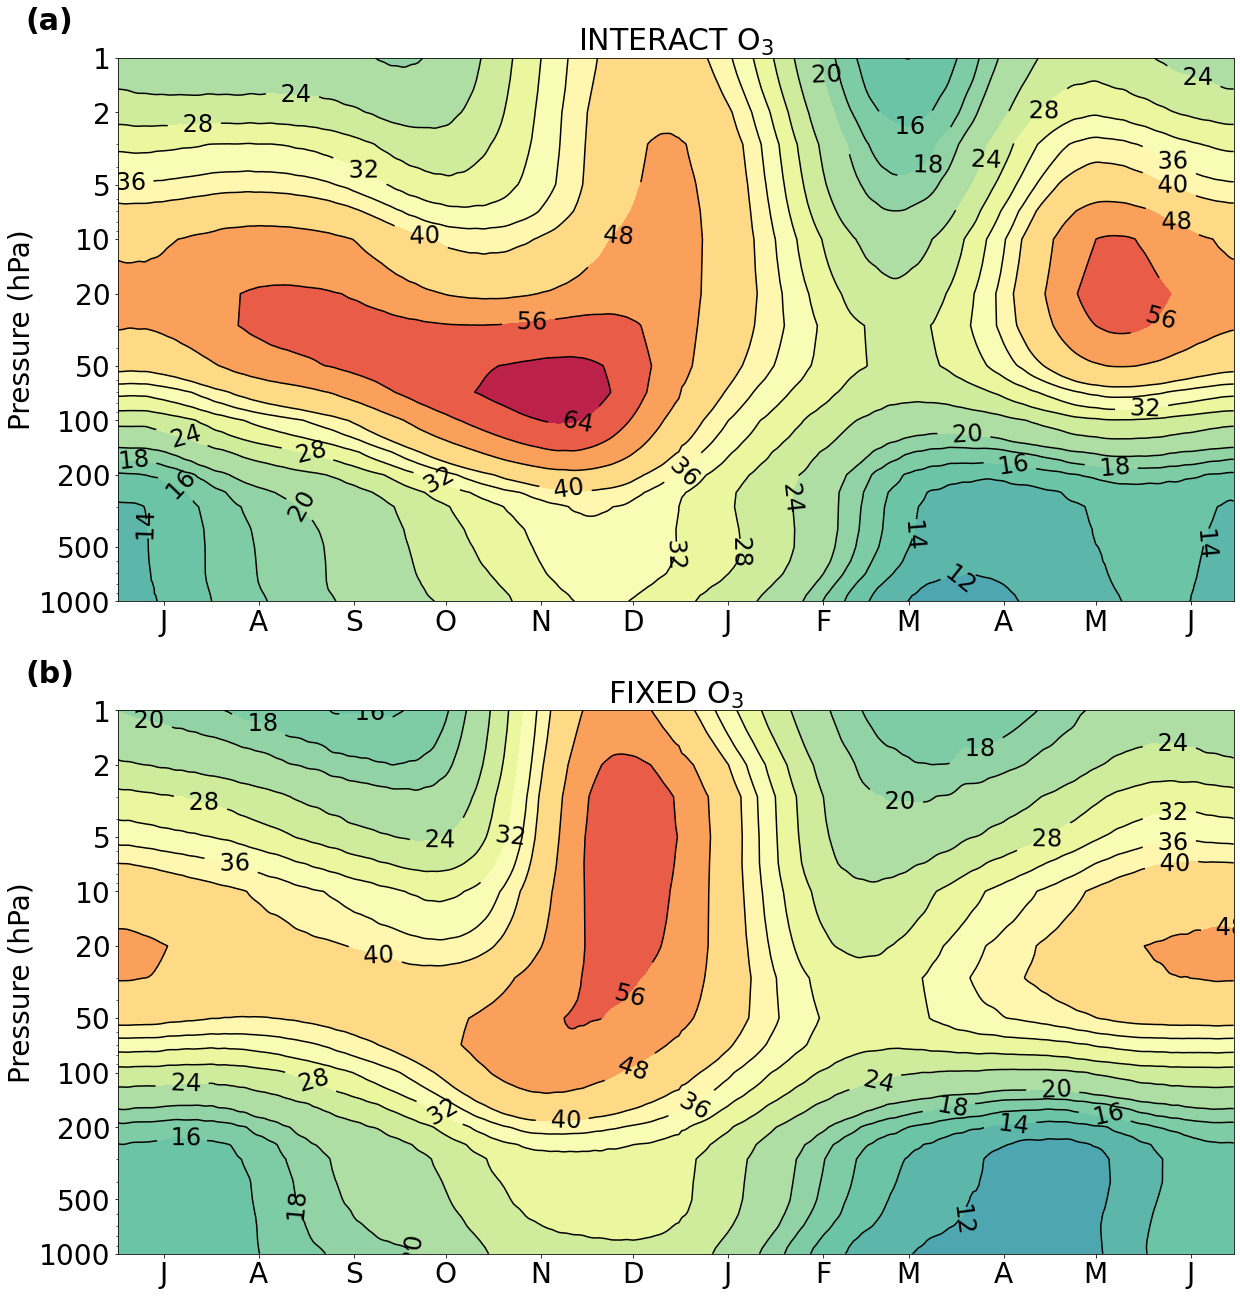

In [14]:
# Ensemble mean
days=np.arange(0,365)
mon_mark = np.array([15, 46, 77, 107, 138, 168, 199, 230, 258, 289, 319, 350]) # mark the 15th of every month
#Switch months to have DJF in the middle of the plot
foci_moz_tau_sw = np.concatenate((foci_moz_smooth[0:23,181:366], foci_moz_smooth[0:23,0:181]), axis=1)
foci_hist_tau_sw = np.concatenate((foci_hist_smooth[0:23,181:366], foci_hist_smooth[0:23,0:181]), axis=1)

#cont = np.array([0,10,20,30,40,50,60,70,80,90,100,120,140,160,180])
cont = np.array([0,8,9,10,12,14,16,18,20,24,28,32,36,40,48,56,64,72])
fig = plt.figure(figsize=(20,22))
plt.subplot(211)
plt.contourf(days, plev, foci_moz_tau_sw, cont)
plt.set_cmap('Spectral_r')
cs=plt.contour(days, plev, foci_moz_tau_sw, cont, colors='k')
plt.clabel(cs, cont, fmt='%3.0f', fontsize=24)

ax = plt.gca()
ax.invert_yaxis()
ax.set_yscale('log')
plt.yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
           ('1', '2', '5', '10', '20', '50', '100', '200', '500', '1000'))
plt.xticks(mon_mark, ('J','A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J'))
ax.tick_params(axis='both', labelsize=28)
#plt.minorticks_on()
#plt.xlabel('Latitude', size=22)
plt.ylabel('Pressure (hPa)', size=28)
plt.title('INTERACT O$_3$', fontsize=30)
plt.text(-30, 0.7, '(a)', fontsize=30, fontweight='bold')

plt.subplot(212)
plt.contourf(days, plev, foci_hist_tau_sw, cont)
plt.set_cmap('Spectral_r')
cs=plt.contour(days, plev, foci_hist_tau_sw, cont, colors='k')
plt.clabel(cs, cont, fmt='%3.0f', fontsize=24)

ax = plt.gca()
ax.invert_yaxis()
ax.set_yscale('log')
plt.yticks([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
           ('1', '2', '5', '10', '20', '50', '100', '200', '500', '1000'))
plt.xticks(mon_mark, ('J','A', 'S', 'O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J'))
ax.tick_params(axis='both', labelsize=28)
#plt.minorticks_on()
#plt.xlabel('Latitude', size=22)
plt.ylabel('Pressure (hPa)', size=28)
plt.title('FIXED O$_3$', fontsize=30)
plt.text(-30, 0.7, '(b)', fontsize=30, fontweight='bold')